In [ ]:
Un problème de vp ???
#image_2019-06-15_10-47-26_1112_64_2.jpg

In [1]:
#D'abord vérifier si on a du Lenet

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing 
from keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics
%matplotlib inline


Using TensorFlow backend.


In [2]:
def build_model (width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [3]:
#Paramètres

#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2


epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.3
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1

In [4]:

base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()


All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    

class: 13
img_paths: 6220


In [5]:
n_path="/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_images/"



fp_new=pd.read_csv("/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_threshold/table_fp_new.csv")

liste_img_paths=[]
for i in range(len(fp_new)):
    liste_img_paths.append(n_path+fp_new["imagetteName"].iloc[i])

fp_new["img_paths"]=liste_img_paths
#imagetteNamefp_new.head()

fp_new["class"]="autre"
fp_new.columns

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index']

fp_new.drop(to_drop,axis=1,inplace=True)

df=pd.concat([df,fp_new])

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [6]:
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input
        # data augmentation
        #rotation_range = 10,
        #zoom_range = zoom_range,
        #horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]

Found 40827 validated image filenames belonging to 6 classes.
Found 10207 validated image filenames belonging to 6 classes.


In [ ]:
val_acc=[]
acc=[]
val_loss=[]
loss=[]

seed(1)
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

Train on 40827 samples, validate on 10207 samples
Epoch 1/10
40827/40827 [==============================] - 39s 945us/sample - loss: 0.3632 - acc: 0.9039 - val_loss: 0.1449 - val_acc: 0.9636
Epoch 2/10
40827/40827 [==============================] - 37s 903us/sample - loss: 0.1359 - acc: 0.9638 - val_loss: 0.0991 - val_acc: 0.9739
Epoch 3/10
40827/40827 [==============================] - 37s 903us/sample - loss: 0.1107 - acc: 0.9696 - val_loss: 0.1126 - val_acc: 0.9677
Epoch 4/10
40827/40827 [==============================] - 35s 869us/sample - loss: 0.0933 - acc: 0.9733 - val_loss: 0.0751 - val_acc: 0.9786
Epoch 5/10
40827/40827 [==============================] - 37s 911us/sample - loss: 0.0842 - acc: 0.9750 - val_loss: 0.0720 - val_acc: 0.9789
Epoch 6/10
40827/40827 [==============================] - 41s 1ms/sample - loss: 0.0726 - acc: 0.9787 - val_loss: 0.0687 - val_acc: 0.9800
Epoch 7/10
40827/40827 [==============================] - 46s 1ms/sample - loss: 0.0642 - acc: 0.9803 - va

In [ ]:
import itertools

val_acc_liste
acc_liste


val_acc_liste = list(itertools.chain(*val_acc))
acc_liste = list(itertools.chain(*acc))

plt.figure(figsize=(16,12))

plt.plot(acc_liste,label="train");
plt.plot(val_acc_liste,label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();


In [ ]:

val_loss_liste = list(itertools.chain(*val_loss))
loss_liste = list(itertools.chain(*loss))

plt.figure(figsize=(16,12))

plt.plot(loss_liste,label="train");
plt.plot(val_loss_liste,label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();

In [ ]:
#99238

In [7]:
val_acc=[]
acc=[]
val_loss=[]
loss=[]

seed(1)
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

Train on 40827 samples, validate on 10207 samples
Epoch 1/10
40827/40827 [==============================] - 30s 731us/sample - loss: 0.3632 - acc: 0.9039 - val_loss: 0.1449 - val_acc: 0.9636
Epoch 2/10
40827/40827 [==============================] - 28s 692us/sample - loss: 0.1359 - acc: 0.9638 - val_loss: 0.0991 - val_acc: 0.9739
Epoch 3/10
40827/40827 [==============================] - 28s 697us/sample - loss: 0.1107 - acc: 0.9696 - val_loss: 0.1126 - val_acc: 0.9677
Epoch 4/10
40827/40827 [==============================] - 28s 696us/sample - loss: 0.0933 - acc: 0.9733 - val_loss: 0.0751 - val_acc: 0.9786
Epoch 5/10
40827/40827 [==============================] - 28s 697us/sample - loss: 0.0842 - acc: 0.9750 - val_loss: 0.0720 - val_acc: 0.9789
Epoch 6/10
40827/40827 [==============================] - 28s 697us/sample - loss: 0.0726 - acc: 0.9787 - val_loss: 0.0687 - val_acc: 0.9800
Epoch 7/10
40827/40827 [==============================] - 28s 698us/sample - loss: 0.0642 - acc: 0.9803 

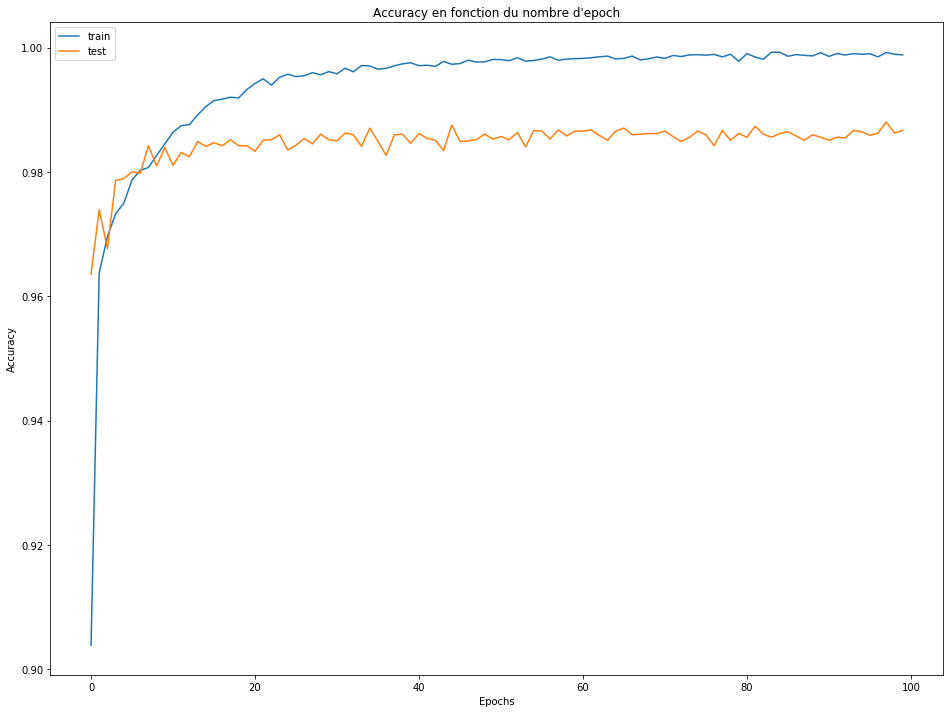

In [9]:
import itertools



val_acc_liste = list(itertools.chain(*val_acc))
acc_liste = list(itertools.chain(*acc))

plt.figure(figsize=(16,12))

plt.plot(acc_liste,label="train");
plt.plot(val_acc_liste,label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();


In [ ]:
#Autour de  0.99238

In [10]:
seed(1)
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=35,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

Train on 40827 samples, validate on 10207 samples
Epoch 1/35
40827/40827 [==============================] - 30s 735us/sample - loss: 0.3632 - acc: 0.9039 - val_loss: 0.1449 - val_acc: 0.9636
Epoch 2/35
40827/40827 [==============================] - 28s 690us/sample - loss: 0.1359 - acc: 0.9638 - val_loss: 0.0991 - val_acc: 0.9739
Epoch 3/35
40827/40827 [==============================] - 29s 716us/sample - loss: 0.1107 - acc: 0.9696 - val_loss: 0.1126 - val_acc: 0.9677
Epoch 4/35
40827/40827 [==============================] - 30s 740us/sample - loss: 0.0933 - acc: 0.9733 - val_loss: 0.0751 - val_acc: 0.9786
Epoch 5/35
40827/40827 [==============================] - 28s 694us/sample - loss: 0.0842 - acc: 0.9750 - val_loss: 0.0720 - val_acc: 0.9789
Epoch 6/35
40827/40827 [==============================] - 28s 690us/sample - loss: 0.0726 - acc: 0.9787 - val_loss: 0.0687 - val_acc: 0.9800
Epoch 7/35
40827/40827 [==============================] - 28s 685us/sample - loss: 0.0642 - acc: 0.9803 